# Spatial Grids

Spatial grid or sometimes spatial index is a spatial indexing system that can be useful when you want to pool or aggregate information from very large spatial maps, such as WSI-level tissue segmentations. `cellseg_gsontools` provides tools to fit spatial index/grid on top of segmentation masks. The grid cells can be further classified based on what's inside of them with any kind of heuristic. For example, cell densities such as lymphocyte densities can be computed by counting the number of cells in each grid cell.

In this notebook, we will demonstrate how to fit a spatial grid on top of a tissue segmentation mask and how to compute cell densities from the nuclei segmentation mask with the spatial index.

## The Data

The data used in this example is a cervical pre-cancerous biopsy. The data is not publicly available, so this serves only as a demonstration of the functionality.

In [1]:
from pathlib import Path
from cellseg_gsontools import read_gdf

tissue_path = Path("/path/to/cervix_lesion_tissues.geojson")
nuc_path = Path("/path/to/cervix_lesion_nuclei.geojson")


tissues = read_gdf(tissue_path)[["geometry", "class_name"]] # take only relevant columns
nuclei = read_gdf(nuc_path)[["geometry", "class_name"]]

tissues.head(5)

,geometry,class_name
0,"POLYGON ((12366.89000 107883.00000, 12296.5200...",areastroma
1,"POLYGON ((8390.00000 117552.00000, 8388.98000 ...",areastroma
2,"POLYGON ((7598.00000 117284.00000, 7596.04000 ...",areastroma
3,"POLYGON ((7564.11000 115883.00000, 7563.15000 ...",areastroma
4,"POLYGON ((6473.29000 112408.03000, 6465.52000 ...",areastroma


In [2]:
nuclei.head(5)

,geometry,class_name
0,"POLYGON ((6502.01000 112825.02000, 6501.01000 ...",connective
1,"POLYGON ((6468.01000 112605.02000, 6468.01000 ...",connective
2,"POLYGON ((6428.00000 112392.02000, 6424.77000 ...",squamous_epithel
3,"POLYGON ((6494.00000 112032.02000, 6490.00000 ...",glandular_epithel
4,"POLYGON ((6466.00000 112432.02000, 6464.01000 ...",connective


<Axes: >

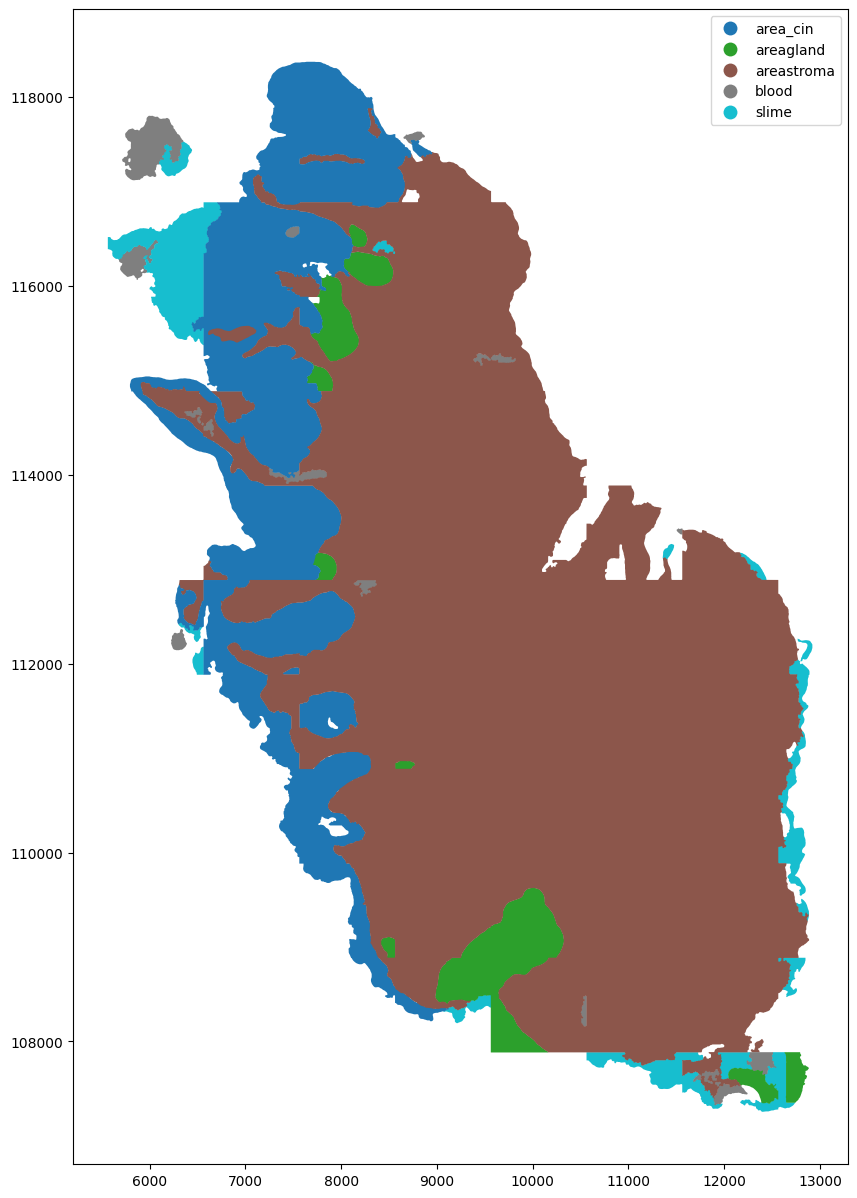

In [3]:
tissues.plot(figsize=(10, 15), column="class_name", legend=True, aspect=None)

<Axes: >

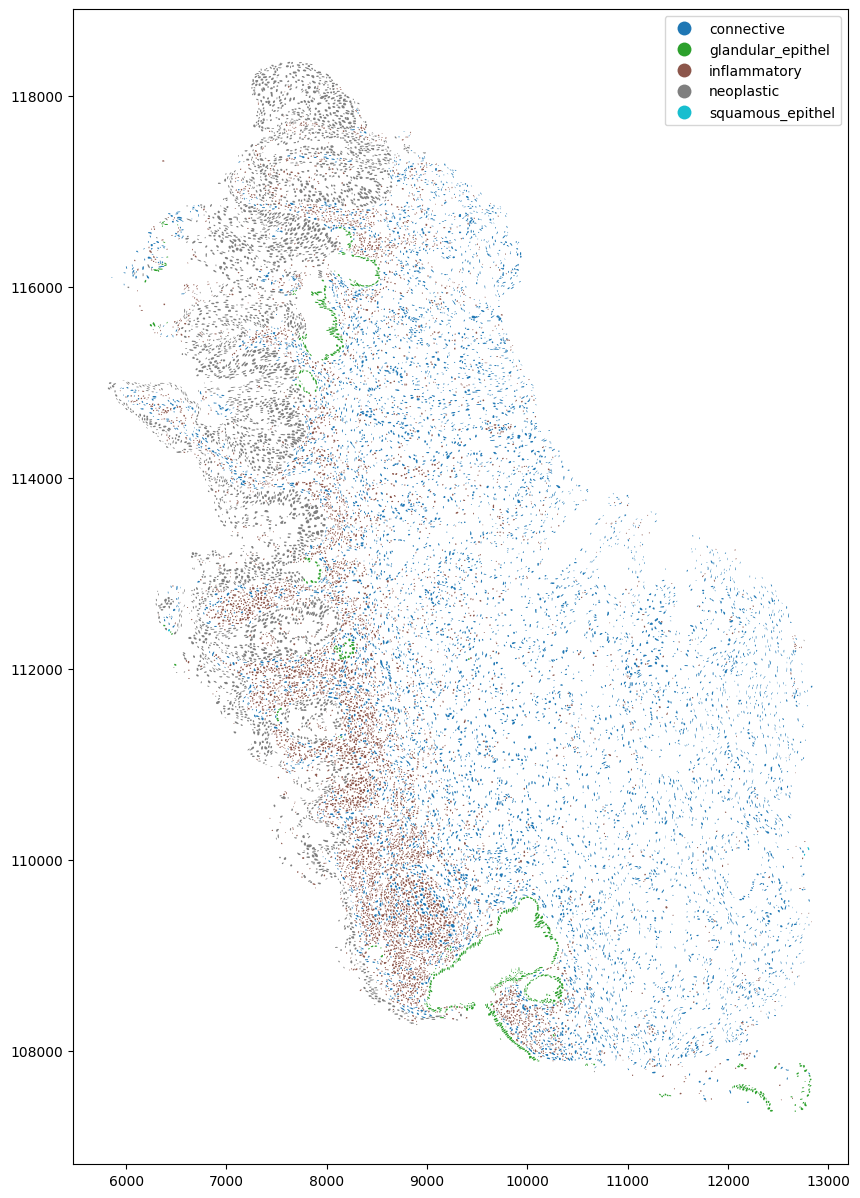

In [4]:
nuclei.plot(figsize=(10, 15), column="class_name", legend=True, aspect=None)

## Fitting a Square Grid

We'll start by demonstrating how to fit a square grid on the tissue mask. The grid can be fitted by using the `grid_overlay`. The `patch_size` and `stride` (patch overlap) needs to be set in pixels to the function. We will use 256x256 patches with no overlap which is basically 128x128 micron tiles in this case.

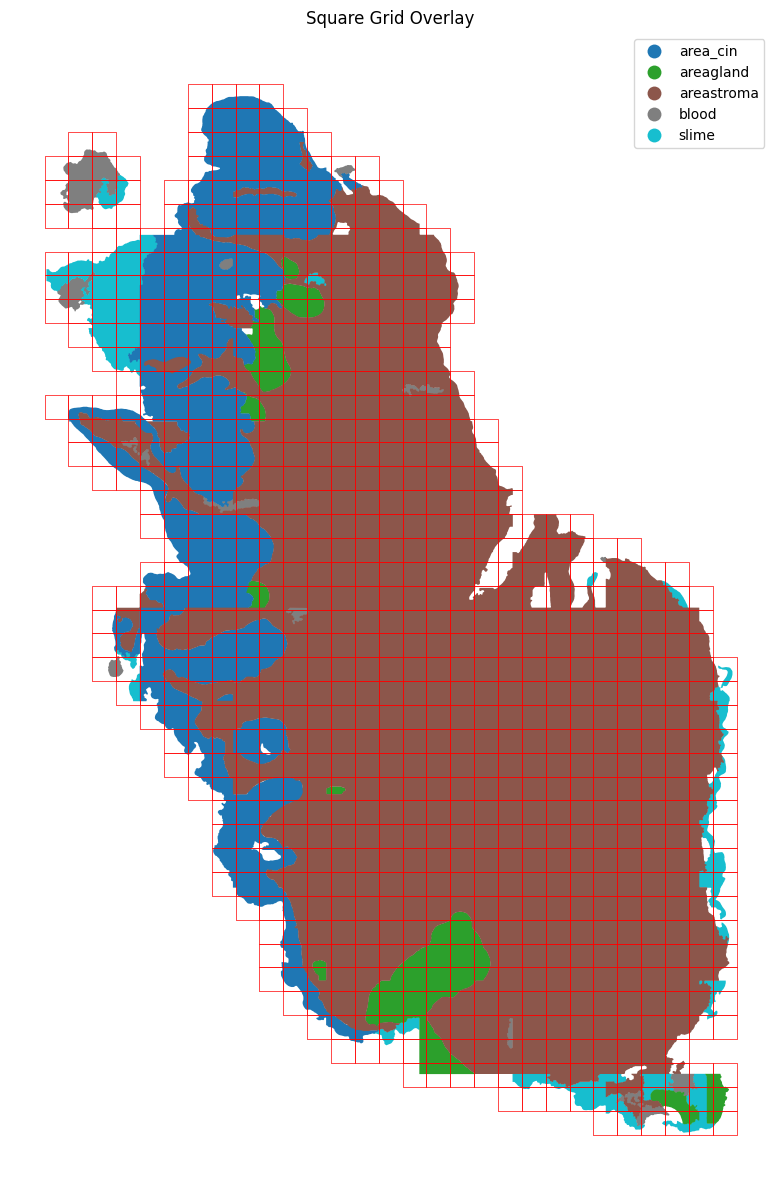

In [20]:
from cellseg_gsontools.grid import grid_overlay

# set the coordinate reference system to avoid annoying warnings
tissues.set_crs(epsg=4328, inplace=True, allow_override=True)

# fit the square grid
grid = grid_overlay(tissues, patch_size=(256, 256), stride=(256, 256))

# plot
ax = tissues.plot(
    figsize=(15, 15),
    column="class_name",
    legend=True,
    aspect=None,
)
grid.boundary.plot(ax=ax, color="red", linewidth=0.5)
ax.set_title("Square Grid Overlay")
ax.set_axis_off()

In [21]:
grid

,geometry,index_right,class_name
23,"POLYGON ((11430.00000 107235.00000, 11686.0000...",14,slime
24,"POLYGON ((11686.00000 107235.00000, 11942.0000...",14,slime
25,"POLYGON ((11942.00000 107235.00000, 12198.0000...",14,slime
48,"POLYGON ((10406.00000 107491.00000, 10662.0000...",14,slime
49,"POLYGON ((10662.00000 107491.00000, 10918.0000...",14,slime
...,...,...,...
1163,"POLYGON ((6310.00000 117475.00000, 6566.00000 ...",32,blood
1190,"POLYGON ((5798.00000 117731.00000, 6054.00000 ...",32,blood
1191,"POLYGON ((6054.00000 117731.00000, 6310.00000 ...",32,blood
1105,"POLYGON ((6310.00000 116963.00000, 6566.00000 ...",20,slime


## Fitting a Hexagonal Grid

Next, we will show how to fit a hexagonal spatial index. The hexagonal grid is fitted by using the `hexgrid_overlay` function. The actual grid is fitted with Uber's [`h3`-package](https://github.com/uber/h3-py). The size of the hexes are determined by the `resolution` parameter. We will be using resolution 10. In the rest of the notebook, we will be using the hexagonal grid to compute the density metrics.

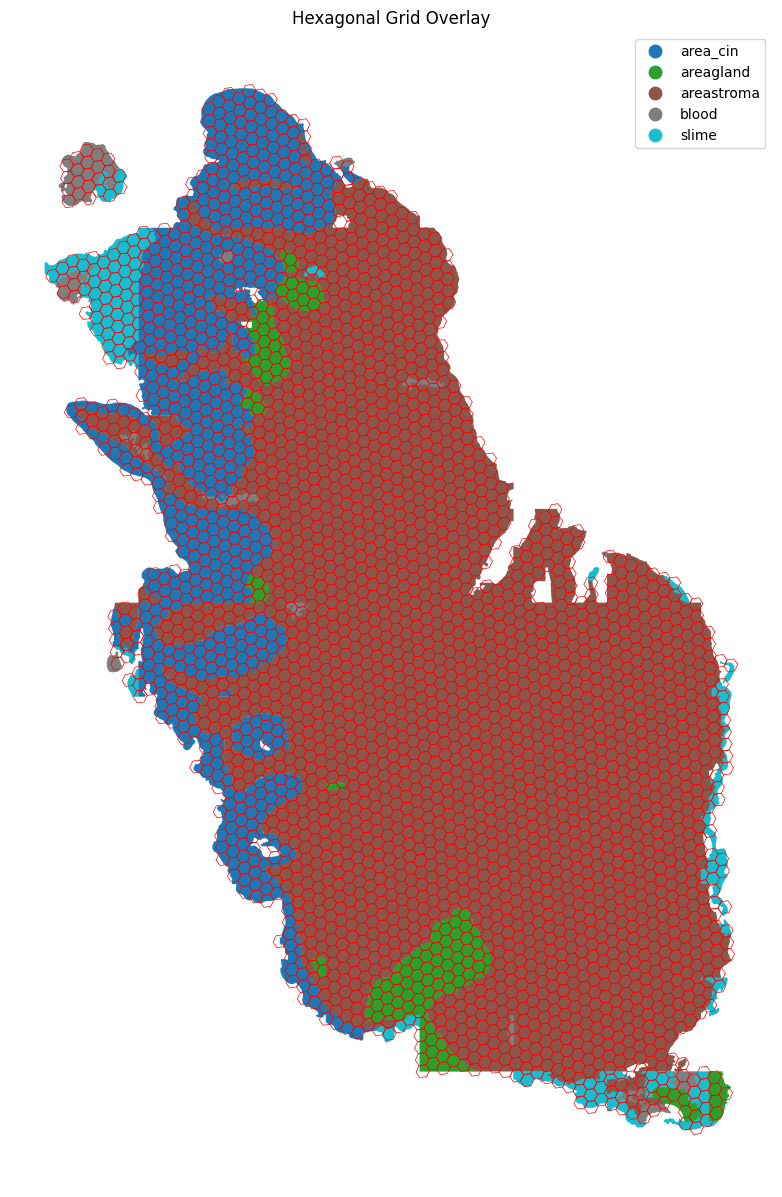

In [22]:
from cellseg_gsontools.grid import hexgrid_overlay

grid = hexgrid_overlay(tissues, resolution=10)
ax = tissues.plot(
    figsize=(15, 15),
    column="class_name",
    legend=True,
    aspect=None,
)

grid.boundary.plot(ax=ax, color="red", linewidth=0.5)
ax.set_title("Hexagonal Grid Overlay")
ax.set_axis_off()

## Immune Cell Densities

Let's now use the grid to compute immune cell densities. We will be using the `grid_classify` function to first compute the immune cell count per hex and then use `mapclassify`-package to bin the count values into bins for visualizing the different levels of immune density.

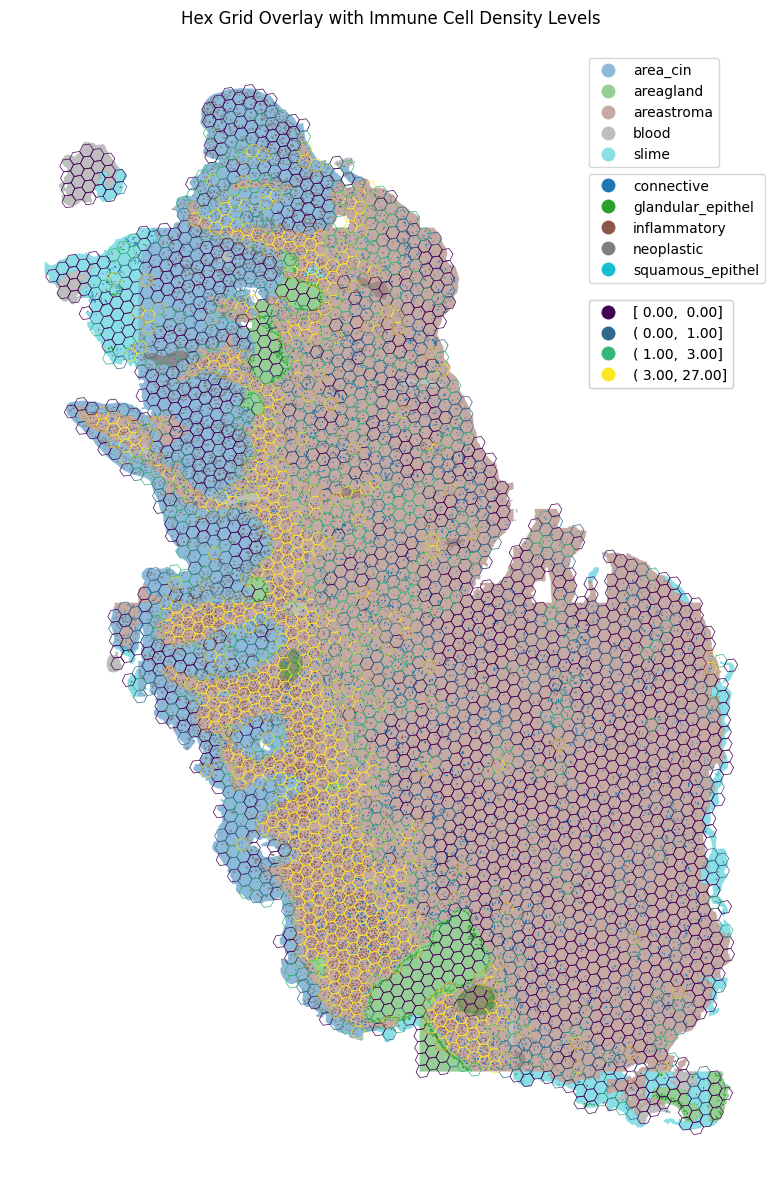

In [23]:
import geopandas as gpd
import mapclassify
import matplotlib.pyplot as plt

from cellseg_gsontools.grid import grid_classify
from cellseg_gsontools.plotting import plot_all


# helper function to replace legend items
def replace_legend_items(legend, mapping):
    for txt in legend.texts:
        for k, v in mapping.items():
            if txt.get_text() == str(k):
                txt.set_text(v)


# Immune cell cnt heuristic to classify the grid cells into two classes
def get_immune_cell_cnt(gdf: gpd.GeoDataFrame, **kwargs) -> int:
    try:
        cnt = gdf.class_name.value_counts()["inflammatory"]
    except KeyError:
        cnt = 0

    return int(cnt)


# Count the immune cells within the grid cells with the cell cnt heuristic
grid = grid_classify(
    grid=grid,
    objs=nuclei,
    metric_func=get_immune_cell_cnt,
    predicate="intersects",
    new_col_names="immune_cnt",
    parallel=False,
)

# bin the grid cells into 4 quantiles
col = "immune_cnt"
bins = mapclassify.Quantiles(grid[col], k=4)
grid["immune_density_level"] = bins.yb

# plot
ax = tissues.plot(
    figsize=(15, 15),
    column="class_name",
    legend=True,
    alpha=0.5,
    legend_kwds={
        "loc": "center left",
        "bbox_to_anchor": (0.75, 0.93)
    }
)
# add the legend to artist, otherwise it will be overwritten
leg1 = ax.legend_
ax.add_artist(leg1)

ax = nuclei.plot(
    ax=ax,
    column="class_name",
    legend=True,
    aspect=None,
    legend_kwds={
        "loc": "center left",
        "bbox_to_anchor": (0.75, 0.83)
    }
)
leg2 = ax.legend_
ax.add_artist(leg2)

# copy the grid for plotting just the boundary
gridboundary = grid.copy()
gridboundary.geometry = grid.geometry.boundary
ax = gridboundary.plot(
    ax=ax,
    column="immune_density_level",
    cmap="viridis",
    legend=True,
    categorical=True,
    linewidth=0.5,
    legend_kwds={
        "loc": "center left",
        "bbox_to_anchor": (0.75, 0.73)
    }
)
leg3 = ax.legend_
ax.add_artist(leg3)

mapping = dict([(i, s) for i, s in enumerate(bins.get_legend_classes())])
replace_legend_items(ax.get_legend(), mapping)

ax.set_title("Hex Grid Overlay with Immune Cell Density Levels")
ax.set_axis_off()
plt.subplots_adjust(right=0.7)

From the plot above we can clearly see that the immune dense areas are clustered close to the pre-cancerous lesion. This is a sign of immune infiltration to the lesion. 

## Distance to the Lesion

Next, we will quantify the distances of the hexes to the lesion. We want to show that the immune dense hexes are closer to the lesion than the immune cold hexes to get a number on it.

In [9]:
# Let's first get the pre-cancerous lesion areas from the tissue gdf
lesions = tissues.loc[tissues.class_name == "area_cin"]
lesions

,geometry,class_name
5,"POLYGON ((8868.11000 117361.00000, 8867.52000 ...",area_cin
6,"POLYGON ((7371.11000 111883.00000, 7370.33000 ...",area_cin
46,"POLYGON ((6562.15000 116294.55000, 6562.00000 ...",area_cin
48,"POLYGON ((7562.07000 111319.52000, 7562.00000 ...",area_cin


### Compute the Minimum Distance to the Lesion

In [10]:
#  Let's now get the distances of the hexes to the unique lesion areas. 
# The final distance will be set to the minimum distance to any lesion area.
import pandas as pd

distances = {}
for i, lesion in lesions.reset_index().iterrows():
    dist = grid.distance(lesion.geometry)
    distances[i] = dist

min_dists = pd.DataFrame(distances).min(axis=1)
min_dists.name = "min_dist"
min_dists

8a82f6472b4ffff       0.000000
8a82f642b8c7fff    3320.611135
8a82f64280affff    4230.460275
8a82f65534c7fff    3490.247847
8a82f64722a7fff       0.000000
                      ...     
8a82f645434ffff     582.169614
8a82f6455507fff    1007.525533
8a82f6455caffff     739.013138
8a82f645426ffff     785.040893
8a82f6455cb7fff     585.208383
Name: min_dist, Length: 3205, dtype: float64

In [11]:
# Let's join the grid df and the min_dists series together
grid = grid.join(other=min_dists, how="left")
grid

,geometry,immune_cnt,immune_density_level,min_dist
8a82f6472b4ffff,"POLYGON ((7356.13395 114373.55572, 7388.89845 ...",0,0,0.000000
8a82f642b8c7fff,"POLYGON ((11580.96929 112350.14187, 11613.7354...",0,0,3320.611135
8a82f64280affff,"POLYGON ((12659.53015 111028.21670, 12692.2971...",1,1,4230.460275
8a82f65534c7fff,"POLYGON ((12649.21585 107557.04820, 12681.9847...",0,0,3490.247847
8a82f64722a7fff,"POLYGON ((7832.15525 115662.20995, 7864.91911 ...",2,2,0.000000
...,...,...,...,...
8a82f645434ffff,"POLYGON ((6398.07752 117381.00075, 6430.84027 ...",0,0,582.169614
8a82f6455507fff,"POLYGON ((6049.25882 117651.55231, 6082.02138 ...",0,0,1007.525533
8a82f6455caffff,"POLYGON ((6072.37958 117269.76002, 6105.14235 ...",0,0,739.013138
8a82f645426ffff,"POLYGON ((6276.66362 117556.02922, 6309.42626 ...",0,0,785.040893


### Filter Stromal Hexes

Let's focus only on the hexes that intersect with the stromal tissue so we can quantify that the stromal immune density is higher close to the lesion. The other tissue regions are not that interesting in this case since we want to quantify whether there is immune infiltration from stroma to the lesion.

In [12]:
stroma = tissues.loc[tissues.class_name == "areastroma"]
stromal_grid = stroma.sjoin(grid, how="inner", predicate="intersects")
stromal_grid

,geometry,class_name,index_right,immune_cnt,immune_density_level,min_dist
0,"POLYGON ((12366.89000 107883.00000, 12296.5200...",areastroma,8a82f642cb6ffff,0,0,3216.916321
0,"POLYGON ((12366.89000 107883.00000, 12296.5200...",areastroma,8a82f642cb4ffff,0,0,3190.945121
1,"POLYGON ((8390.00000 117552.00000, 8388.98000 ...",areastroma,8a82f6454537fff,7,3,0.000000
1,"POLYGON ((8390.00000 117552.00000, 8388.98000 ...",areastroma,8a82f6454507fff,12,3,0.000000
1,"POLYGON ((8390.00000 117552.00000, 8388.98000 ...",areastroma,8a82f645450ffff,2,2,0.000000
...,...,...,...,...,...,...
55,"POLYGON ((6553.06000 114438.00000, 6552.38000 ...",areastroma,8a82f6409347fff,2,2,16.394966
55,"POLYGON ((6553.06000 114438.00000, 6552.38000 ...",areastroma,8a82f6409357fff,1,1,0.000000
55,"POLYGON ((6553.06000 114438.00000, 6552.38000 ...",areastroma,8a82f640935ffff,0,0,0.000000
55,"POLYGON ((6553.06000 114438.00000, 6552.38000 ...",areastroma,8a82f6454cb7fff,0,0,0.000000


### Plot Distance Distributions

In [13]:
# Let's tidy up the gird data for plotting the distance distributions

tidy = stromal_grid.reset_index().set_index("immune_density_level")
tidy = tidy[["min_dist"]]
tidy = tidy.stack()
tidy = tidy.reset_index()
tidy = tidy.rename(
    columns={
        "immune_density_level": "Stromal Immune Density Level",
        "level_1": "Attribute",
        0: "Distance to Lesion"
    }
)
tidy

,Stromal Immune Density Level,Attribute,Distance to Lesion
0,0,min_dist,3216.916321
1,0,min_dist,3190.945121
2,3,min_dist,0.000000
3,3,min_dist,0.000000
4,2,min_dist,0.000000
...,...,...,...
2586,2,min_dist,16.394966
2587,1,min_dist,0.000000
2588,0,min_dist,0.000000
2589,0,min_dist,0.000000


Let's plot the kernel density estimate and a swarmplot for the different immune density levels to see the differences between the immune density level distributions in the stroma.

In [14]:
# !pip install seaborn

Text(0.5, 1.0, 'Swarm - Distances to Lesion')

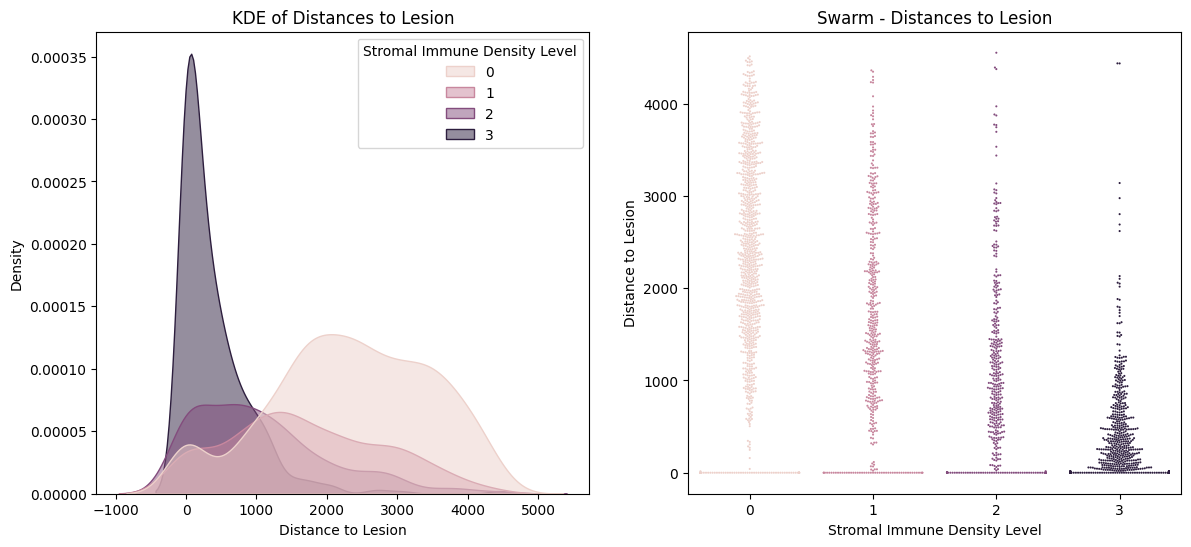

In [25]:
import seaborn as sns

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

ax[0] = sns.kdeplot(
    ax=ax[0],
    data=tidy,
    x="Distance to Lesion",
    hue="Stromal Immune Density Level",
    fill=True,
    alpha=0.5,
)
ax[0].set_title("KDE of Distances to Lesion")

ax[1] = sns.swarmplot(
    ax=ax[1],
    data=tidy,
    y="Distance to Lesion",
    x="Stromal Immune Density Level",
    hue="Stromal Immune Density Level",
    size=1.5,
    orient="v",
    legend=False,
    warn_thresh=0.5,
)
ax[1].set_title("Swarm - Distances to Lesion")

From the plots, it's quite clear that the immune dense hexes are closer to the lesion than the immune cold hexes. This is a clear sign of immune infiltration from stroma to the lesion.

Finally, let's compute whether the distance distributions are statistically significantly different between the immune density levels. We will do a t-test on two independent samples to see if the difference in the mean distances is statistically significant. We'll use the `scipy.stats.ttest_ind` function for this.

In [32]:
# !pip install scipy

In [33]:
from scipy.stats import ttest_ind

# Filter the immune hot and cold hexes
immune_hot = stromal_grid.loc[stromal_grid["immune_density_level"] == 3]
immune_cold = stromal_grid.loc[stromal_grid["immune_density_level"] == 0]

# Get the distances for immune hot and cold hexes
# standardize the distances
immune_hot.loc[:, "min_dist"] = (
    immune_hot["min_dist"] / immune_hot["min_dist"].mean()
) / immune_hot["min_dist"].std()
immune_cold.loc[:, "min_dist"] = (
    immune_cold["min_dist"] / immune_cold["min_dist"].mean()
) / immune_cold["min_dist"].std()

dist_hot = immune_hot["min_dist"]
dist_cold = immune_cold["min_dist"]

# Perform the t-test
statistic, p_value = ttest_ind(dist_hot, dist_cold)

# Print the results
if p_value < 0.05:
    print("The immune hot hexes are significantly closer to the lesion than the immune cold hexes.")
else:
    print("There is no significant difference in distance between the immune hot and cold hexes.")

print("p-value: ", p_value)

The immune hot hexes are significantly closer to the lesion than the immune cold hexes.
p-value:  3.282143798145504e-33


From this, we can conclude that the immune dense hexes are very very significantly closer to the lesion than the immune cold hexes. This is a clear sign of immune infiltration from stroma to the lesion, although, it is also clear just by eyeballing. However, it's always good to get a number to it.

In [34]:
# sizes of the groups
len(dist_hot), len(dist_cold)

(659, 1025)